In [1]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Prepare images

In [2]:
cImPath = './Bren.jpg'
sImPath = './berni_retrato.jpg'
genImOutputPath = './output.jpg'

In [3]:
targetHeight = 512
targetWidth = 512
targetSize = (targetHeight, targetWidth)

cImage = load_img(path=cImPath, target_size=targetSize)
cImArr = img_to_array(cImage)
cImArr = K.variable(preprocess_input(np.expand_dims(cImArr, axis=0)), dtype='float32')

sImage = load_img(path=sImPath, target_size=targetSize)
sImArr = img_to_array(sImage)
sImArr = K.variable(preprocess_input(np.expand_dims(sImArr, axis=0)), dtype='float32')

gIm0 = np.random.randint(256, size=(targetWidth, targetHeight, 3)).astype('float64')
gIm0 = preprocess_input(np.expand_dims(gIm0, axis=0))
gImPlaceholder = K.placeholder(shape=(1, targetWidth, targetHeight, 3))

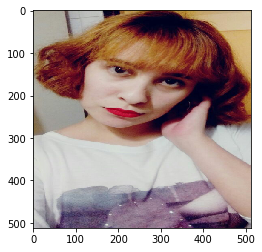

In [4]:
plt.imshow(cImage)

## Content loss function

$$L_{content}(p,x,l) =  \frac{1}{2} \sum{(F^{l}_{ij} - P^{l}_{ij})^2} $$

In [5]:
def get_feature_reps(x, layer_names, model):
    """
    Get feature representations of input x for one or more layers in a given model.
    """
    featMatrices = []
    for ln in layer_names:
        selectedLayer = model.get_layer(ln)
        featRaw = selectedLayer.output
        featRawShape = K.shape(featRaw).eval(session=tf_session)
        N_l = featRawShape[-1]
        M_l = featRawShape[1]*featRawShape[2]
        featMatrix = K.reshape(featRaw, (M_l, N_l))
        featMatrix = K.transpose(featMatrix)
        featMatrices.append(featMatrix)
    return featMatrices

In [6]:
def get_content_loss(F, P):
    cLoss = 0.5*K.sum(K.square(F - P))
    return cLoss

## Style loss function

- **Gram matrix ** $G^{l} = F^{l}*(F^{l})^{T}$
- **Style loss for a given layer** $E_{l} =  \frac{1}{4*N^{2}_{l}*M^{2}_{l}} \sum{(G^{l}_{ij} - A^{l}_{ij})^2} $
- **Style loss function ** $L_{style}(a,x,l) = \sum{w_{l}*E_{l}} $

In [7]:
def get_Gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

In [8]:
def get_style_loss(ws, Gs, As):
    sLoss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_Gram_matrix(G)
        A_gram = get_Gram_matrix(A)
        #TODO: tensorflow deprecate +=
        sLoss = sLoss + w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return sLoss

## Total loss function

$$L(p,a,x,l) = \alpha*L_{c}(p,x,l) + \beta*L_{s}(a,x,l) $$

In [10]:
def get_total_loss(gImPlaceholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[cLayerName], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=sLayerNames, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    totalLoss = alpha*contentLoss + beta*styleLoss
    return totalLoss

In [11]:
def calculate_loss(gImArr):
    if gImArr.shape != (1, targetWidth, targetWidth, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    loss_fcn = K.function([gModel.input], [get_total_loss(gModel.input)])
    return loss_fcn([gImArr])[0].astype('float64')


In [12]:
def get_grad(gImArr):

    if gImArr.shape != (1, targetWidth, targetHeight, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    grad_fcn = K.function([gModel.input], 
                          K.gradients(get_total_loss(gModel.input), [gModel.input]))
    grad = grad_fcn([gImArr])[0].flatten().astype('float64')
    return grad

In [ ]:
from keras.applications import VGG16
from scipy.optimize import fmin_l_bfgs_b

tf_session = K.get_session()
cModel = VGG16(include_top=False, weights='imagenet', input_tensor=cImArr)
sModel = VGG16(include_top=False, weights='imagenet', input_tensor=sImArr)
gModel = VGG16(include_top=False, weights='imagenet', input_tensor=gImPlaceholder)
cLayerName = 'block4_conv2'
sLayerNames = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                ]

P = get_feature_reps(x=cImArr, layer_names=[cLayerName], model=cModel)[0]
As = get_feature_reps(x=sImArr, layer_names=sLayerNames, model=sModel)
ws = np.ones(len(sLayerNames))/float(len(sLayerNames))

iterations = 600
x_val = gIm0.flatten()
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_val, fprime=get_grad,
                            maxiter=iterations, disp=True)